In [1]:
from autodp import rdp_acct
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
path_project = os.path.dirname(os.path.abspath('.'))
import sys
sys.path.append(os.path.join(path_project, 'src'))
sys.path.append(os.path.join(path_project, 'exp/script'))

import options

img_path = os.path.join(path_project, 'exp', 'img')
pickle_path = os.path.join(path_project, 'exp', 'pickle')
results_path = os.path.join(path_project, 'exp', 'results')
default_args = options.build_default_args(path_project)

import copy
from run_simulation import run_simulation

from mylogger import logger_set_debug, logger_set_info, logger_set_warning
from opacus.accountants import RDPAccountant

import pickle

def RDP_gaussian_with_C(sigma, alpha, C):
    assert(sigma > 0)
    assert(alpha >= 0)
    return 0.5 * C**2 / sigma ** 2 * alpha

In [2]:
Q_LIST_SIZE = 30

# binary search given q_u
def from_q_u(q_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_sensitivity_u = 100
    min_sensitivity_u = 0
    while True:
        sensitivity_u = (max_sensitivity_u + min_sensitivity_u) / 2
        # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_sensitivity_u = sensitivity_u
        else:
            max_sensitivity_u = sensitivity_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return sensitivity_u, eps


# binary search given_sensitivity_u
def from_sensitivity_u(sensitivity_u, delta, epsilon_u, sigma, T, m=100, precision=1e-6):
    max_q_u = 1.0
    min_q_u = 0
    # func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
    while True:
        q_u = (max_q_u + min_q_u) / 2
        # accountant = rdp_acct.anaRDPacct(m=m)
        accountant = RDPAccountant()
        for i in range(T):
            # accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
            accountant.step(noise_multiplier=sigma/sensitivity_u, sample_rate=q_u)
        # eps = accountant.get_eps(delta)
        eps = accountant.get_epsilon(delta=delta)
        if eps < epsilon_u:
            min_q_u = q_u
        else:
            max_q_u = q_u
        if 0 < epsilon_u - eps and epsilon_u - eps < precision:
            return q_u, eps
        

# qCカーブを書くために，適当にqを選んでCを計算して点をプロットする
def make_q_c_curve(epsilon_u, delta, sigma, n_round=100, num_points=20, min=-5):
    T = n_round

    num_points = num_points // 3 * 2
    x = np.logspace(min, -1, num_points).tolist() + np.linspace(0.15, 1.0, int(num_points/2)).tolist()
    y = []
    for q_u in x:
        sensitivity_u, eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
        assert eps <= epsilon_u, f"eps={eps} > epsilon_u={epsilon_u}"
        # print("sensitivity_u =", sensitivity_u, "eps =", eps)
        y.append(sensitivity_u)
    return x, y


def plot_q_c_curve(x, y, title="", log=True):
    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_subplot(111)
    ax.plot(x, y, marker='o', label='sensitivity_u')
    for i, (xi, yi) in enumerate(zip(x, y)):
        if i % 5 == 0:
            ax.annotate(f"({xi:.5f}, {yi:.5f})", (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')
    # q*C の値をプロット
    ax.plot(x, np.array(x)*np.array(y), marker='x', linestyle='--', color='red', label='product_x*y')
    print("Max idx", np.argmax(np.array(x)*np.array(y)))
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_xlabel("q_u")
    ax.set_ylabel("sensitivity_u")
    ax.set_title(title)
    plt.show()


# epsilon_uのリストを受け取り，C_uとq_uを作る
def make_params(epsilon_u_dct, delta, sigma, n_round, q_step_size=None, q_u=None, C_u=None, idx=None):
    C_u_dct = {}
    q_u_dct = {}

    if idx is not None:
        assert q_u is None and C_u is None, "idx is not None and q_u or C_u is not None"
        n_of_q_u = Q_LIST_SIZE
        q_u_list = []
        init_q_u = 1.0
        for _ in range(n_of_q_u):
            q_u_list.append(init_q_u)
            init_q_u *= q_step_size
        q_u = q_u_list[idx]

    cache = {}
    for user_id, eps_u in epsilon_u_dct.items():
        if cache.get(eps_u) is None:
            if q_u is None:
                q_u, _eps = from_sensitivity_u(sensitivity_u=C_u, delta=delta, epsilon_u=eps_u, sigma=sigma, T=n_round)
                assert _eps <= eps_u, f"_eps={_eps} > eps_u={eps_u}"
                cache[eps_u] = q_u
            elif C_u is None:
                C_u, _eps = from_q_u(q_u=q_u, delta=delta, epsilon_u=eps_u, sigma=sigma, T=n_round)
                assert _eps <= eps_u, f"_eps={_eps} > eps_u={eps_u}"
                cache[eps_u] = C_u
            else:
                raise ValueError("both q_u and C_u are not None")
        else:
            if q_u is None:
                q_u = cache[eps_u]
            elif C_u is None:
                C_u = cache[eps_u]
        C_u_dct[user_id] = C_u
        q_u_dct[user_id] = q_u

    return C_u_dct, q_u_dct


def fed_simulation(
    delta, 
    sigma, 
    n_users, 
    C_u=None, 
    q_u=None, 
    q_step_size=None,
    times=1, 
    user_dist="uniform-iid", 
    silo_dist="uniform", 
    dataset_name="light_mnist", 
    global_learning_rate=10.0, 
    clipping_bound=1.0,
    n_round=10, 
    local_epochs=50, 
    local_learning_rate=0.01,
    agg_strategy="PULDP-AVG",
    epsilon_u=None,
    group_thresholds=None,
):
    args = options.build_default_args(path_project)

    if dataset_name == "heart_disease":
        from flamby_utils.heart_disease import update_args

        args = update_args(args)

    elif dataset_name == "tcga_brca":
        from flamby_utils.tcga_brca import update_args

        args = update_args(args)

    args.dataset_name = dataset_name
    args.agg_strategy = agg_strategy
    args.n_total_round = n_round
    args.n_users = n_users
    args.local_epochs = local_epochs
    args.times = times

    args.user_dist = user_dist
    args.silo_dist = silo_dist
    args.global_learning_rate = global_learning_rate
    args.local_learning_rate = local_learning_rate
    args.clipping_bound = clipping_bound

    args.delta = delta
    args.sigma = sigma
    args.C_u = C_u
    args.q_u = q_u
    args.q_step_size = q_step_size
    args.epsilon_u = epsilon_u
    args.group_thresholds = group_thresholds
    args.dry_run = False
    args.secure_w = False

    results_list = []
    for i in range(args.times):
        # print("======== TIME:", i, "start")
        args.seed = args.seed + i
        try:
            sim_results = run_simulation(args, path_project)
            results_list.append(sim_results)
        except OverflowError:
            results_list.append("LOSS IS NAN")
        except AssertionError:
            results_list.append("Assertion Error")

    return results_list


def calc_metric(results):
    acc_list = np.array([r['global']['global_test'][-1][1] for r in results])
    loss_list = np.array([r['global']['global_test'][-1][2] for r in results])
    acc_mean, acc_std, loss_mean, loss_std = np.mean(acc_list), np.std(acc_list), np.mean(loss_list), np.std(loss_list)
    return acc_mean, acc_std, loss_mean, loss_std


def make_epsilon_u(epsilon=1.0, n_users=0, dist="homo", epsilon_list=[], ratio_list=[]) -> dict[int, float]:
    if dist == "homo":
        epsilon_u = {user_id: epsilon for user_id in range(n_users)}
    elif dist == "hetero":
        assert len(epsilon_list) > 0 and len(ratio_list) > 0
        epsilon_u_list = np.random.choice(epsilon_list, size=n_users, p=ratio_list)
        epsilon_u = {user_id: epsilon_u_list[user_id] for user_id in range(n_users)}
    else:
        raise ValueError(f"invalid dist {dist}")
    return epsilon_u

# Check monotonically increasing between q and C for epsilon

In [ ]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 1000

q_u_list = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.8, 0.99]
sensitivity_u_list = [0.01, 0.1, 1.0, 5.0, 10, 100]
data = []

for q_u in q_u_list:
    for sensitivity_u in sensitivity_u_list:
        func_gaussian = lambda x: RDP_gaussian_with_C(sigma, x, sensitivity_u)
        accountant = rdp_acct.anaRDPacct(m=100)
        for i in range(T):
            accountant.compose_subsampled_mechanisms_lowerbound(func=func_gaussian, prob=q_u)
        eps = accountant.get_eps(delta)
        if eps < 1e10:
            data.append((q_u, sensitivity_u, eps))
        else:
            continue


# for q_u in q_u_list
fig = plt.figure(figsize=(15, 2))
for i, q_u in enumerate(q_u_list):
    filtered_data = [d for d in data if d[0] == q_u]
    x = [d[1] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(q_u_list), i+1)
    ax.plot(x, y, label='q_u = {}'.format(q_u), marker='o')
    ax.set_title('q_u = {}'.format(q_u), size=14)
    ax.set_xlabel('sensitivity_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

# for sensitivity_u in sensitivity_u_list
fig = plt.figure(figsize=(18, 2))
for i, sensitivity_u in enumerate(sensitivity_u_list):
    filtered_data = [d for d in data if d[1] == sensitivity_u]
    x = [d[0] for d in filtered_data]
    y = [d[2] for d in filtered_data]
    ax = fig.add_subplot(1, len(sensitivity_u_list), i+1)
    ax.plot(x, y, label='sensitivity_u = {}'.format(sensitivity_u), marker='o')
    ax.set_title('sensitivity_u = {}'.format(sensitivity_u), size=14)
    ax.set_xlabel('q_u', size=14)
    if i == 0:
        ax.set_ylabel('epsilon', size=14)
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_ylim(0, epsilon_u+1.0)
plt.show()

# Binary Search based method

- `accountant = rdp_acct.anaRDPacct(m=m)`
    - Zhu, Yuqing, and Yu-Xiang Wang. "Poission subsampled rényi differential privacy." International Conference on Machine Learning. PMLR, 2019.
- `accountant = RDPAccountant()`
    - Mironov, Ilya, Kunal Talwar, and Li Zhang. "R\'enyi differential privacy of the sampled gaussian mechanism." arXiv preprint arXiv:1908.10530 (2019).

In [ ]:
delta = 1e-5
sigma = 5.0
epsilon_u = 5.0
T = 100

sensitivity_u, eps = from_q_u(q_u=0.1, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("sensitivity_u =", sensitivity_u, "eps =", eps)

q_u, eps = from_sensitivity_u(sensitivity_u=1.59, delta=delta, epsilon_u=epsilon_u, sigma=sigma, T=T)
print("q_u =", q_u, "eps =", eps)

# Observation
- to observe what happens with various sensitivity and sampling rate

Parameters
- epsilon_u, delta_u
    - privacy budgets for each users
- homo, hetero
    - distribution of privacy budgets for each users

### Plotting the pairs

In [ ]:
epsilon_u = 3.0
n_round = 20
delta = 1e-5
for sigma in [0.5]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

In [ ]:
epsilon_u = 3.0
n_round = 10
delta = 1e-5
for sigma in [0.5]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=True)

In [ ]:
delta = 1e-5
# epsilon_u = 1.0
# sigma = 0.5
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")

# epsilon_u = 10.0
# n_round = 100
# for n_round in [10, 100, 1000]:
#     x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=0.5, num_points=30, n_round=n_round, min=-6)
#     plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")


epsilon_u = 3.0
n_round = 20
sigma = 0.5
for epsilon_u in [0.11, 1.0, 5.0, 10.0]:
    x, y = make_q_c_curve(epsilon_u=epsilon_u, delta=delta, sigma=sigma, num_points=30, n_round=n_round, min=-6)
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}")
    plot_q_c_curve(x, y, title=f"n_round = {n_round}, epsilon_u = {epsilon_u}, delta = {delta}, sigma = {sigma}", log=False)


# Machine Learning

## try different q C pairs

In [15]:
def try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, start_idx: int = 0, end_idx: int = 12, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30):
    try:
        with open(os.path.join(pickle_path, f'different_qC_result_{n_users}_{dataset_name}_{epsilon_g}_{sigma}_{n_round}_{delta}_{q_step_size}.pkl'), 'rb') as file:
            results_dict = pickle.load(file)
    except FileNotFoundError:
        results_dict = {}

    logger_set_warning()

    for idx in list(range(Q_LIST_SIZE))[start_idx:end_idx]:
        epsilon_u_dct = make_epsilon_u(epsilon=epsilon_g, n_users=n_users, dist="homo")
        C_u, q_u = make_params(epsilon_u_dct, delta, sigma, n_round, idx=idx, q_step_size=q_step_size)
        print("C_u:", C_u[0], "q_u:", q_u[0])

        result = fed_simulation(
            delta, sigma, n_users, C_u, q_u, q_step_size,
            times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", agg_strategy="PULDP-AVG",
            global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name, local_epochs=local_epochs
        )
        results_dict[idx] = (q_u, C_u, result)

        # print("idx: ", idx)
        # acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
        # print(f"ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    with open(os.path.join(pickle_path, f'different_qC_result_{n_users}_{dataset_name}_{epsilon_g}_{sigma}_{n_round}_{delta}_{q_step_size}.pkl'), 'wb') as file:
        pickle.dump(results_dict, file)

def show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size):
    with open(os.path.join(pickle_path, f'different_qC_result_{n_users}_{dataset_name}_{epsilon_g}_{sigma}_{n_round}_{delta}_{q_step_size}.pkl'), 'rb') as file:
        results_dict = pickle.load(file)

    plt.figure(figsize=(10, 5)) 
    x = list(results_dict.keys())
    q_u_list = [results_dict[i][0][0] for i in x]
    C_u_list = [results_dict[i][1][0] for i in x]
    y = [calc_metric(results_dict[i][2])[2] for i in x]  # loss_mean
    error = [calc_metric(results_dict[i][2])[3] for i in x]  # loss_std
    plt.errorbar(x, y, yerr=error, fmt='-o')
    for i in range(len(x)):
        plt.text(x[i], y[i]*1.02, f'q={q_u_list[i]:.3f}\nC={C_u_list[i]:.3f}', fontsize=8)
    plt.title('Loss Mean with Standard Deviation over different idx')
    plt.xlabel('idx')
    plt.ylabel('Loss Mean')
    plt.show()


### heart disease

C_u: 0.14581717550754547 q_u: 1.0
C_u: 0.18167532980442047 q_u: 0.8
C_u: 0.22616013884544373 q_u: 0.6400000000000001
C_u: 0.2812623977661133 q_u: 0.5120000000000001
C_u: 0.3493551164865494 q_u: 0.40960000000000013
C_u: 0.43320432305336 q_u: 0.32768000000000014
C_u: 0.5360245704650879 q_u: 0.2621440000000001
C_u: 0.6614744663238525 q_u: 0.2097152000000001
C_u: 0.8137181401252747 q_u: 0.1677721600000001
C_u: 0.9964913129806519 q_u: 0.13421772800000006
C_u: 1.2140125036239624 q_u: 0.10737418240000006
C_u: 1.468399167060852 q_u: 0.08589934592000005


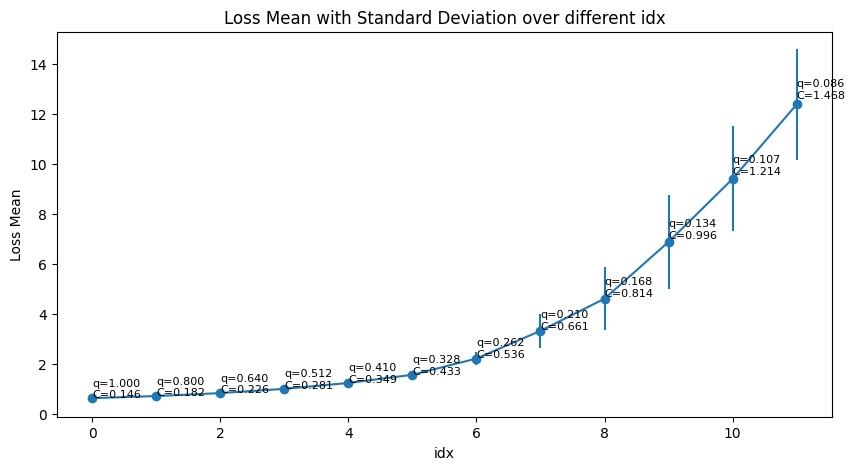

In [121]:
sigma = 5.0
epsilon_g = 0.5
delta = 1e-5
n_users = 100
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)

C_u: 0.029163435101509094 q_u: 1.0
C_u: 0.036335038021206856 q_u: 0.8
C_u: 0.045232055708765984 q_u: 0.6400000000000001
C_u: 0.05625244230031967 q_u: 0.5120000000000001
C_u: 0.06987098604440689 q_u: 0.40960000000000013
C_u: 0.08664093911647797 q_u: 0.32768000000000014
C_u: 0.10720491409301758 q_u: 0.2621440000000001
C_u: 0.1322949305176735 q_u: 0.2097152000000001
C_u: 0.16274377703666687 q_u: 0.1677721600000001
C_u: 0.1992981880903244 q_u: 0.13421772800000006
C_u: 0.24280250072479248 q_u: 0.10737418240000006
C_u: 0.29367953538894653 q_u: 0.08589934592000005


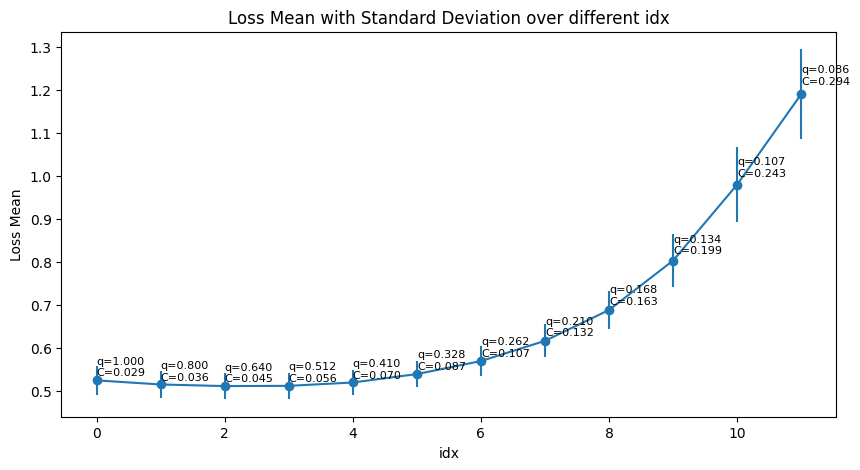

In [124]:
sigma = 1.0
epsilon_g = 0.5
delta = 1e-5
n_users = 100
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)

C_u: 0.029163435101509094 q_u: 1.0
C_u: 0.036335038021206856 q_u: 0.8
C_u: 0.045232055708765984 q_u: 0.6400000000000001
C_u: 0.05625244230031967 q_u: 0.5120000000000001
C_u: 0.06987098604440689 q_u: 0.40960000000000013
C_u: 0.08664093911647797 q_u: 0.32768000000000014
C_u: 0.10720491409301758 q_u: 0.2621440000000001
C_u: 0.1322949305176735 q_u: 0.2097152000000001
C_u: 0.16274377703666687 q_u: 0.1677721600000001
C_u: 0.1992981880903244 q_u: 0.13421772800000006
C_u: 0.24280250072479248 q_u: 0.10737418240000006
C_u: 0.29367953538894653 q_u: 0.08589934592000005


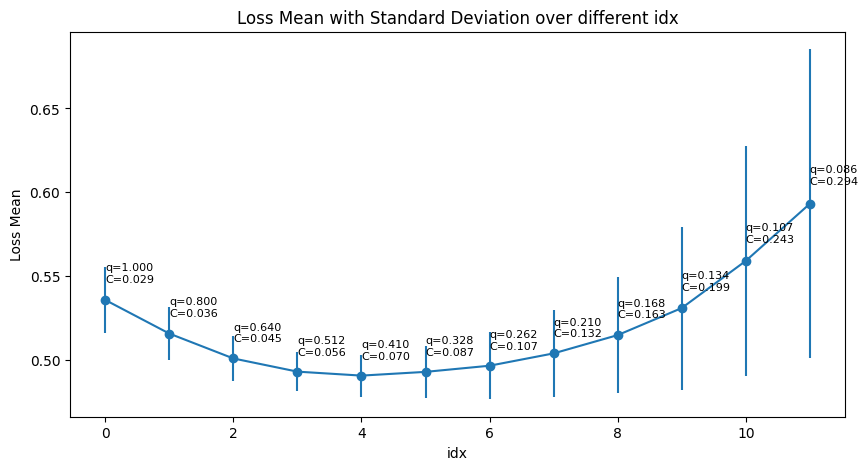

In [125]:
sigma = 1.0
epsilon_g = 0.5
delta = 1e-5
n_users = 300
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)

C_u: 0.14581717550754547 q_u: 1.0
C_u: 0.18167532980442047 q_u: 0.8
C_u: 0.22616013884544373 q_u: 0.6400000000000001
C_u: 0.2812623977661133 q_u: 0.5120000000000001
C_u: 0.3493551164865494 q_u: 0.40960000000000013
C_u: 0.43320432305336 q_u: 0.32768000000000014
C_u: 0.5360245704650879 q_u: 0.2621440000000001
C_u: 0.6614744663238525 q_u: 0.2097152000000001
C_u: 0.8137181401252747 q_u: 0.1677721600000001
C_u: 0.9964913129806519 q_u: 0.13421772800000006
C_u: 1.2140125036239624 q_u: 0.10737418240000006
C_u: 1.468399167060852 q_u: 0.08589934592000005


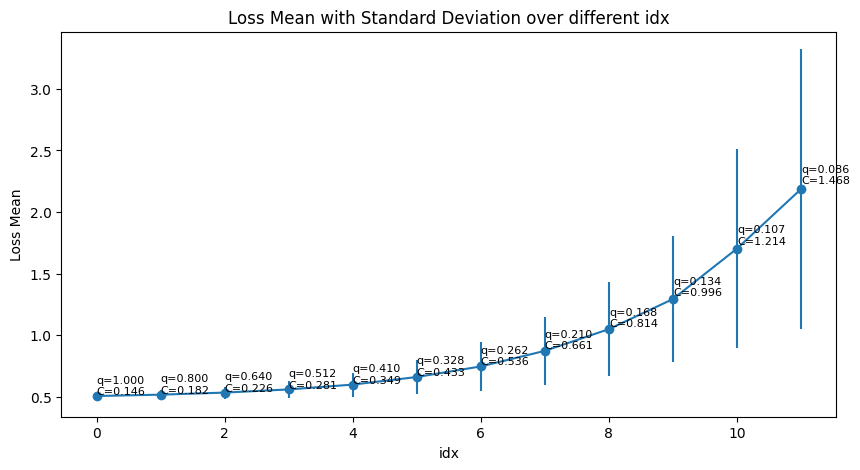

In [126]:
sigma = 5.0
epsilon_g = 0.5
delta = 1e-5
n_users = 300
n_round = 20
dataset_name = 'heart_disease'
q_step_size = 0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)

### tcga brca

C_u: 0.014581717550754547 q_u: 1.0
C_u: 0.018167519010603428 q_u: 0.8
C_u: 0.022616027854382992 q_u: 0.6400000000000001
C_u: 0.028126221150159836 q_u: 0.5120000000000001
C_u: 0.034935493022203445 q_u: 0.40960000000000013
C_u: 0.04332046955823898 q_u: 0.32768000000000014
C_u: 0.05360245704650879 q_u: 0.2621440000000001
C_u: 0.06614746525883675 q_u: 0.2097152000000001
C_u: 0.08137188851833344 q_u: 0.1677721600000001
C_u: 0.0996490940451622 q_u: 0.13421772800000006
C_u: 0.12140125036239624 q_u: 0.10737418240000006
C_u: 0.14683976769447327 q_u: 0.08589934592000005


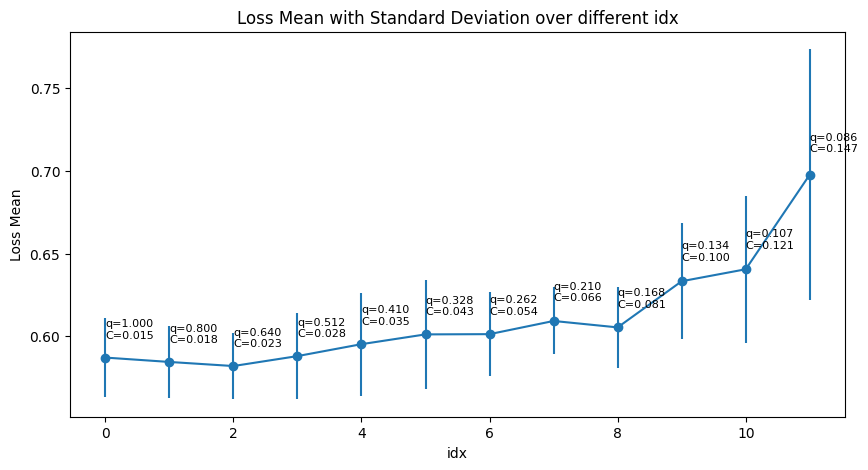

In [127]:
sigma = 0.5
epsilon_g = 0.5
delta = 1e-5
n_users = 100
n_round = 20
dataset_name = 'tcga_brca'
q_step_size=0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)

C_u: 0.17601288855075836 q_u: 0.06871947673600004
C_u: 0.20852461457252502 q_u: 0.054975581388800036
C_u: 0.24230461567640305 q_u: 0.043980465111040035
C_u: 0.27057453989982605 q_u: 0.03518437208883203
C_u: 0.2943214029073715 q_u: 0.028147497671065627


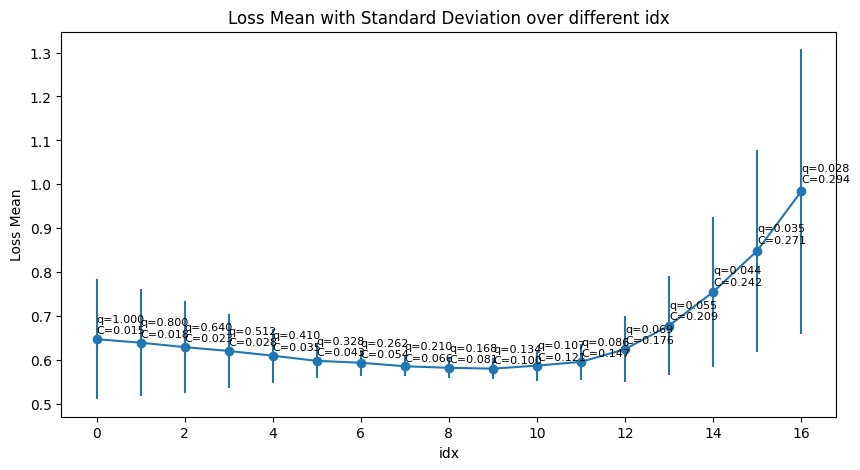

In [136]:
sigma = 0.5
epsilon_g = 0.5
delta = 1e-5
n_users = 300
n_round = 20
dataset_name = 'tcga_brca'
q_step_size=0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.001, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)


C_u: 0.061134935822337866 q_u: 1.0
C_u: 0.07551799062639475 q_u: 0.8
C_u: 0.0929911620914936 q_u: 0.6400000000000001
C_u: 0.11404692195355892 q_u: 0.5120000000000001
C_u: 0.1391491387039423 q_u: 0.40960000000000013
C_u: 0.16865702345967293 q_u: 0.32768000000000014
C_u: 0.20273462869226933 q_u: 0.2621440000000001
C_u: 0.2411882858723402 q_u: 0.2097152000000001
C_u: 0.28335643000900745 q_u: 0.1677721600000001
C_u: 0.3281101118773222 q_u: 0.13421772800000006
C_u: 0.3738586325198412 q_u: 0.10737418240000006
C_u: 0.41911029256880283 q_u: 0.08589934592000005


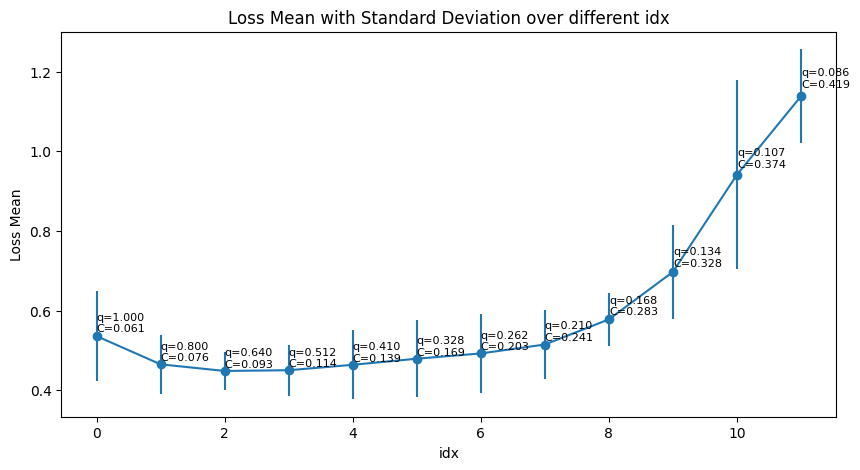

In [18]:
sigma = 0.5
epsilon_g = 3.0
delta = 1e-5
n_users = 300
n_round = 30
dataset_name = 'creditcard'
q_step_size=0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)


C_u: 0.586600648239255 q_u: 0.06871947673600004
C_u: 0.6305217277258635 q_u: 0.054975581388800036
C_u: 0.672271940857172 q_u: 0.043980465111040035


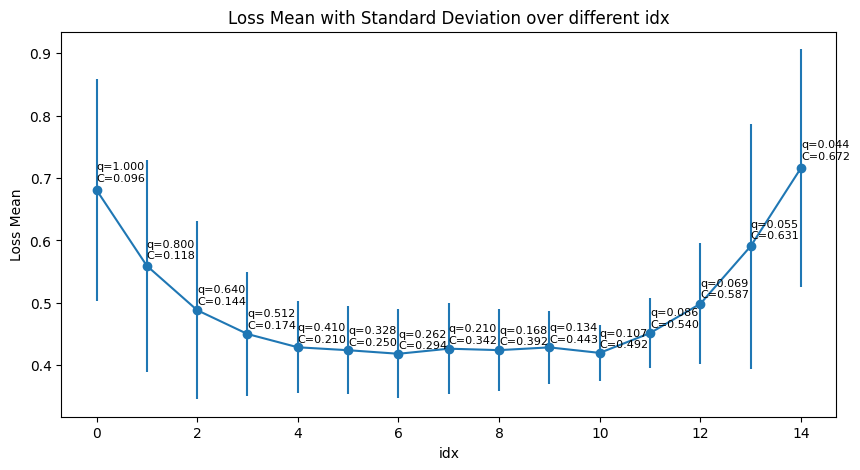

In [17]:
sigma = 0.5
epsilon_g = 5.0
delta = 1e-5
n_users = 1000
n_round = 30
dataset_name = 'creditcard'
q_step_size=0.8
times = 5

logger_set_warning()
try_different_qC_pairs(sigma, epsilon_g, delta, n_users, n_round, dataset_name, times, q_step_size, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30, start_idx=12, end_idx=15)
show_try_different_qC_pairs_result(sigma, epsilon_g, delta, n_users, n_round, dataset_name, q_step_size)


## Single Epsilon setting

#### given q C

##### what step size should be suitable for q_u

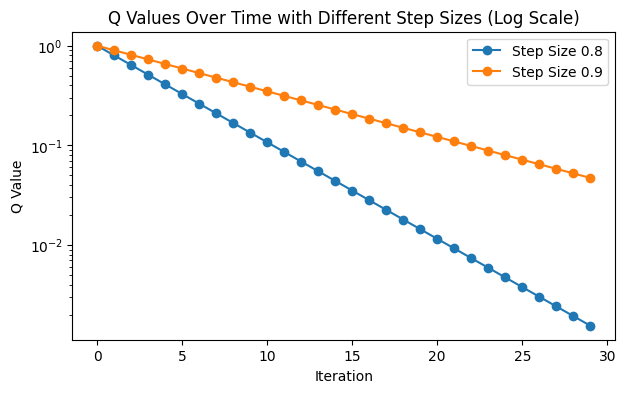

In [25]:
# 各ステップサイズに対するq_listを計算
step_size = [0.8, 0.9]
all_q_lists = []
for step in step_size:
    q_list = []
    init_q = 1.0
    for _ in range(30):
        q_list.append(init_q)
        init_q *= step
    all_q_lists.append(q_list)

plt.figure(figsize=(7, 4))
for i, q_list in enumerate(all_q_lists):
    plt.plot(q_list, label=f'Step Size {step_size[i]}', marker='o')
plt.yscale('log')
plt.title('Q Values Over Time with Different Step Sizes (Log Scale)')
plt.xlabel('Iteration')
plt.ylabel('Q Value')
plt.legend()
plt.show()

##### run with specified idx

In [158]:
def run_with_specified_idx(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, idx, q_step_size, times):
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list)
    C_u, q_u = make_params(epsilon_u, delta, sigma, n_round, idx=idx, q_step_size=q_step_size)
    print("C_u:", C_u[0], ", q_u:", q_u[0])
    result = fed_simulation(
        delta, sigma, n_users, C_u=C_u, q_u=q_u, agg_strategy="PULDP-AVG",
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=10.0, local_learning_rate=0.01, dataset_name=dataset_name,
        local_epochs=30,
        epsilon_u=epsilon_u,
        group_thresholds=group_thresholds,
    )
    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
    print(f"ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}_{idx}_{q_step_size}.pkl'), 'wb') as file:
        pickle.dump(result, file)


In [170]:
n_users = 300
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'heart_disease'
n_round=30
idx = 4
q_step_size = 0.8
times = 5

logger_set_warning()
run_with_specified_idx(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, idx, q_step_size, times)


C_u: 0.2782982774078846 , q_u: 0.40960000000000013
ACC: 0.7921 ± 0.0080 , LOSS: 0.4679 ± 0.0072


In [214]:
n_users = 100
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'tcga_brca'
n_round = 30
idx = 2
q_step_size = 0.8
times = 5

logger_set_warning()
run_with_specified_idx(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, idx, q_step_size, times)


C_u: 0.0929911620914936 , q_u: 0.6400000000000001
ACC: 0.7560 ± 0.0471 , LOSS: 0.5582 ± 0.0137


#### online optimization

In [4]:
def run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=10.0, local_learning_rate=0.01, local_epochs=30):
    epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list)
    result = fed_simulation(
        delta, sigma, n_users, C_u=None, q_u=None, q_step_size=q_step_size, agg_strategy="PULDP-AVG-online",
        times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
        global_learning_rate=global_learning_rate, local_learning_rate=local_learning_rate, dataset_name=dataset_name,
        local_epochs=local_epochs,
        epsilon_u=epsilon_u,
        group_thresholds=group_thresholds,
    )

    acc_mean, acc_std, loss_mean, loss_std = calc_metric(result)
    print(f"ACC: {acc_mean:.4f} ± {acc_std:.4f}", f", LOSS: {loss_mean:.4f} ± {loss_std:.4f}")

    with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}_{q_step_size}.pkl'), 'wb') as file:
        pickle.dump(result, file)

def show_online_optimization_result(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size):
    with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}_{q_step_size}.pkl'), 'rb') as file:
        result = pickle.load(file)

    # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
    eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

    fig, ax1 = plt.subplots()
    for eps_u in eps_u_values:
        # 各辞書からeps_uに対応するデータを集める
        all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

        # 平均値と標準偏差を計算
        means = np.mean(all_data, axis=0)
        stds = np.std(all_data, axis=0)

        # 平均値と標準偏差をプロット
        x = range(len(means))
        y1 = [item[0] for item in means]
        y2 = [item[1] for item in means]
        error1 = [item[0] for item in stds]
        error2 = [item[1] for item in stds]

        ax1.errorbar(x, y1, yerr=error1, label=f'eps_u={eps_u} q_u', alpha=0.5)
        ax1.errorbar(x, y2, yerr=error2, label=f'eps_u={eps_u} C_u', alpha=0.5)

    loss_means = []
    loss_stds = []
    acc_means = []
    acc_stds = []

    # 各ラウンドに対して処理
    for i in range(len(result[0]['global']['global_test'])):
        # その位置における全ラウンドのloss値を集める
        losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
        accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

        loss_means.append(np.mean(losses_at_position))
        loss_stds.append(np.std(losses_at_position))

        acc_means.append(np.mean(accs_at_position))
        acc_stds.append(np.std(accs_at_position))

    ax2 = ax1.twinx()
    ax2.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss', color='red', alpha=0.5)
    ax1.set_yscale('log')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('q_u and C_u')
    ax2.set_ylabel('Test Loss')
    ax2.set_yscale('log')
    plt.title('q_u and C_u with Test Loss')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    # グラフの表示
    plt.show()

    fig, ax = plt.subplots()
    ax.errorbar(x, acc_means, yerr=acc_stds, label=f'Test Accuracy', color='red', alpha=0.5)
    ax.set_xlabel('Round')
    ax.set_ylabel('Test Accuracy')
    ax.set_title('Test Accuracy')
    ax.legend(loc='upper left')
    plt.show()


In [5]:
def show_online_optimization_result_from_n_users_list(n_users_list, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, optimal_dct=None):
    _, ax_q = plt.subplots()
    _, ax_loss = plt.subplots()
    for n_users in n_users_list:
        with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}_{q_step_size}.pkl'), 'rb') as file:
            result = pickle.load(file)

        # eps_uの値のリストを取得（すべての辞書から共通のキーを抽出）
        eps_u_values = set(key for dct in result for key in dct["param_history"].keys())

        for eps_u in eps_u_values:
            # 各辞書からeps_uに対応するデータを集める
            all_data = np.array([dct["param_history"][eps_u][:-1] for dct in result if eps_u in dct["param_history"]])

            # 平均値と標準偏差を計算
            means = np.mean(all_data, axis=0)
            stds = np.std(all_data, axis=0)

            # 平均値と標準偏差をプロット
            x = range(len(means))
            y1 = [item[0] for item in means]
            error1 = [item[0] for item in stds]
            ax_q.errorbar(x, y1, yerr=error1, label=f'q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

        loss_means = []
        loss_stds = []
        acc_means = []
        acc_stds = []

        # 各ラウンドに対して処理
        for i in range(len(result[0]['global']['global_test'])):
            # その位置における全ラウンドのloss値を集める
            losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
            accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

            loss_means.append(np.mean(losses_at_position))
            loss_stds.append(np.std(losses_at_position))

            acc_means.append(np.mean(accs_at_position))
            acc_stds.append(np.std(accs_at_position))
    
        ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss n_users={n_users}', alpha=0.5)

    
    # optimal q_u
    if optimal_dct is not None and type(optimal_dct) is dict:
        for (eps_u, n_users, idx), q_u in optimal_dct.items():
            with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}_{idx}_{q_step_size}.pkl'), 'rb') as file:
                result = pickle.load(file)

            loss_means = []
            loss_stds = []
            acc_means = []
            acc_stds = []

            for i in range(len(result[0]['global']['global_test'])):
                losses_at_position = [result[round_id]['global']['global_test'][i][2] for round_id in range(len(result))]
                accs_at_position = [result[round_id]['global']['global_test'][i][1] for round_id in range(len(result))]

                loss_means.append(np.mean(losses_at_position))
                loss_stds.append(np.std(losses_at_position))

                acc_means.append(np.mean(accs_at_position))
                acc_stds.append(np.std(accs_at_position))
            
            ax_loss.errorbar(x, loss_means, yerr=loss_stds, label=f'Test Loss optimal q C eps_u={eps_u} n_users={n_users}', alpha=0.5)
            ax_q.errorbar(x, [q_u]*len(x), yerr=[0.0]*len(x), label=f'Optimal q_u eps_u={eps_u} n_users={n_users}', alpha=0.9)

    ax_q.set_yscale('log')
    ax_q.set_xlabel('Round')
    ax_q.set_ylabel('q_u')
    ax_q.legend(loc='lower left')

    ax_loss.set_ylabel('Test Loss')
    ax_loss.set_yscale('log')
    ax_loss.legend(loc='upper right')

    # グラフの表示
    plt.show()

n_users: 100
n_users: 200
n_users: 300


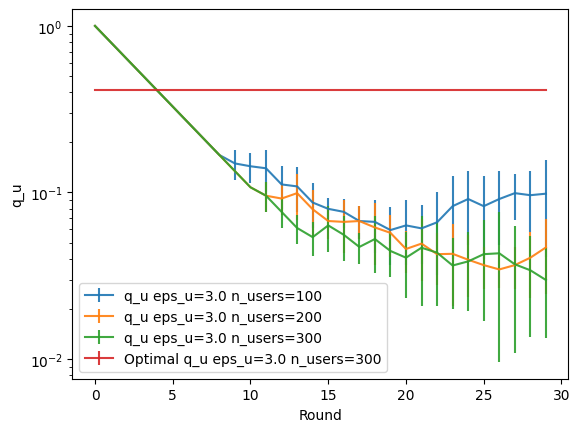

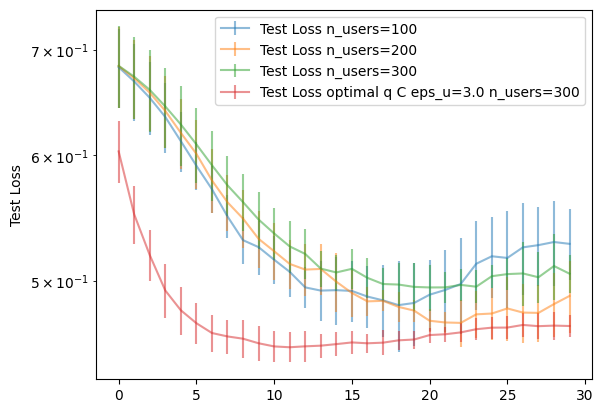

In [209]:
# heart disease with different delta
n_users_list = [100, 200, 300]
sigma = 1.0
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'heart_disease'
n_round = 30
q_step_size = 0.8
times = 5

for n_users in n_users_list:
    print("n_users:", n_users)
    # run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=1.0, local_epochs=50)
    # show_online_optimization_result(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size)

show_online_optimization_result_from_n_users_list(n_users_list, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, optimal_dct={(3.0, 300, 4): 0.41})


n_users: 100


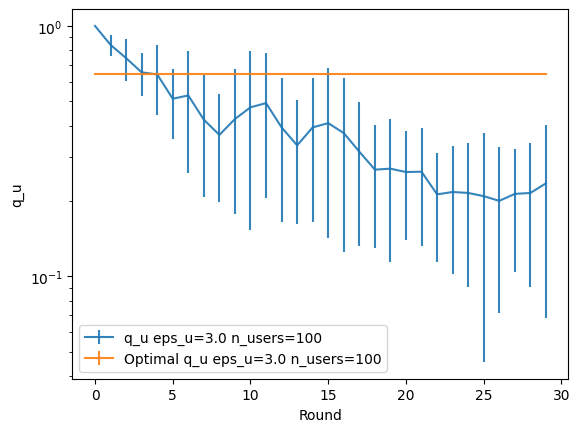

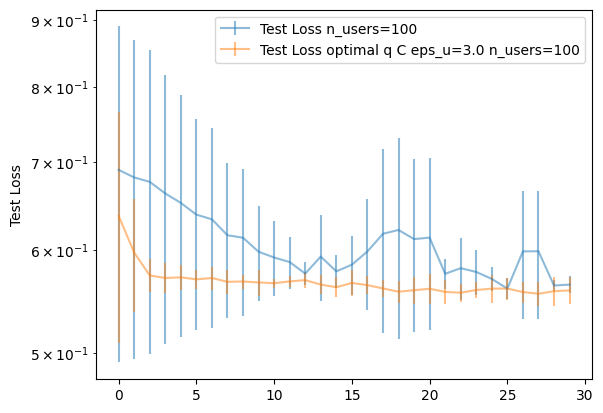

In [216]:
# herat disease with different delta
n_users_list = [100]
sigma = 0.5
epsilon_list = [3.0]
group_thresholds = [3.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'tcga_brca'
n_round = 30
q_step_size = 0.8
times = 5

for n_users in n_users_list:
    print("n_users:", n_users)
    # run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=1.0, local_epochs=50)
    # show_online_optimization_result(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size)
show_online_optimization_result_from_n_users_list(n_users_list, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, optimal_dct={(3.0, 100, 2): 0.64})


n_users: 100
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=100, n_silos=5, user_dist='zipf-iid', silo_dist='zipf', user_alpha=0.3, silo_alpha=1.5, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=50, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='PULDP-AVG-online', group_k=2, sigma=0.5, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=0, hyper_parameter_tuning=None, times=3, exp_dist=None, version=0, C_u=None, q_u=None, q_step_size=0.8, epsilon_u={0: 10.0, 1: 10.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0, 9: 10.0, 10: 10.0, 11: 10.0, 12: 10.0, 13: 10.0, 14: 10.0, 15: 10.0, 16: 10.0, 17: 10.0, 18: 10.0, 19: 10.0, 20: 10.0, 21: 10.0, 22: 10.0, 23: 10.0, 24: 10.0, 25: 10.0, 26: 10.0, 27: 10.0, 28: 10.0, 29: 10.0, 30: 10.0, 31: 10.0, 32: 10.0, 33: 10.0, 34: 10.0, 35: 10.0, 36: 10.0, 37

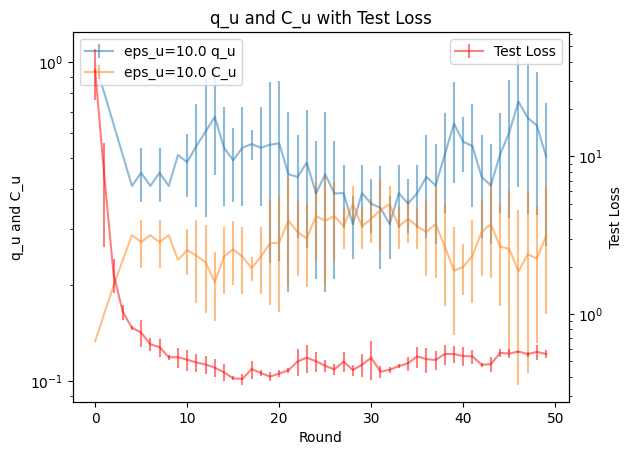

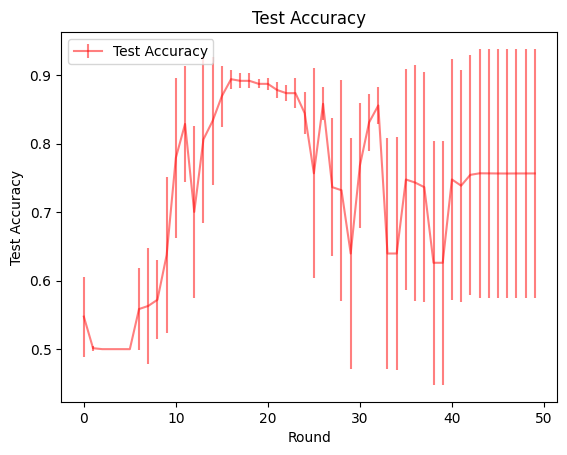

n_users: 1000
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=1000, n_silos=5, user_dist='zipf-iid', silo_dist='zipf', user_alpha=0.3, silo_alpha=1.5, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=50, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='PULDP-AVG-online', group_k=2, sigma=0.5, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=0, hyper_parameter_tuning=None, times=3, exp_dist=None, version=0, C_u=None, q_u=None, q_step_size=0.8, epsilon_u={0: 10.0, 1: 10.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0, 9: 10.0, 10: 10.0, 11: 10.0, 12: 10.0, 13: 10.0, 14: 10.0, 15: 10.0, 16: 10.0, 17: 10.0, 18: 10.0, 19: 10.0, 20: 10.0, 21: 10.0, 22: 10.0, 23: 10.0, 24: 10.0, 25: 10.0, 26: 10.0, 27: 10.0, 28: 10.0, 29: 10.0, 30: 10.0, 31: 10.0, 32: 10.0, 33: 10.0, 34: 10.0, 35: 10.0, 36: 10.0, 

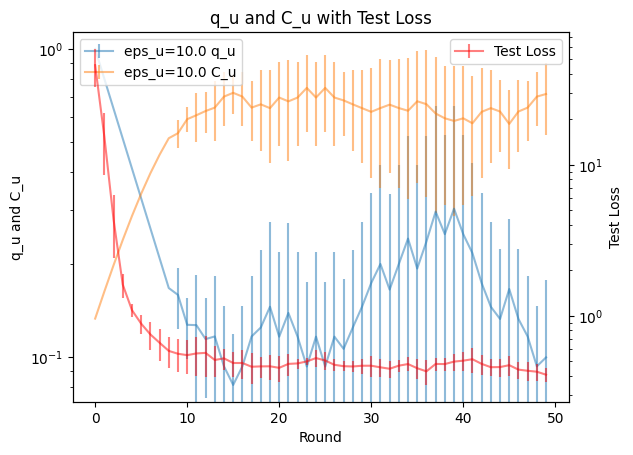

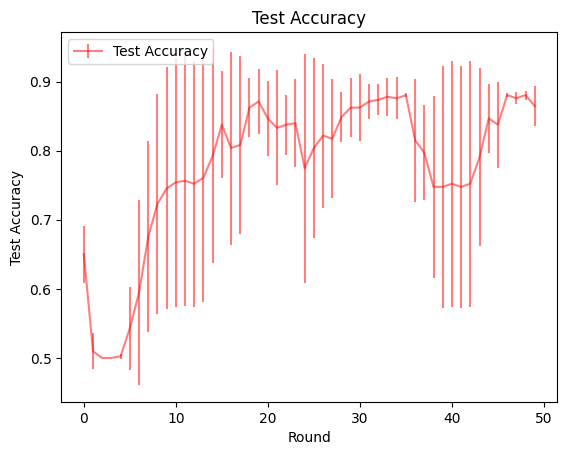

n_users: 2000
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=2000, n_silos=5, user_dist='zipf-iid', silo_dist='zipf', user_alpha=0.3, silo_alpha=1.5, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=50, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='PULDP-AVG-online', group_k=2, sigma=0.5, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=0, hyper_parameter_tuning=None, times=3, exp_dist=None, version=0, C_u=None, q_u=None, q_step_size=0.8, epsilon_u={0: 10.0, 1: 10.0, 2: 10.0, 3: 10.0, 4: 10.0, 5: 10.0, 6: 10.0, 7: 10.0, 8: 10.0, 9: 10.0, 10: 10.0, 11: 10.0, 12: 10.0, 13: 10.0, 14: 10.0, 15: 10.0, 16: 10.0, 17: 10.0, 18: 10.0, 19: 10.0, 20: 10.0, 21: 10.0, 22: 10.0, 23: 10.0, 24: 10.0, 25: 10.0, 26: 10.0, 27: 10.0, 28: 10.0, 29: 10.0, 30: 10.0, 31: 10.0, 32: 10.0, 33: 10.0, 34: 10.0, 35: 10.0, 36: 10.0, 

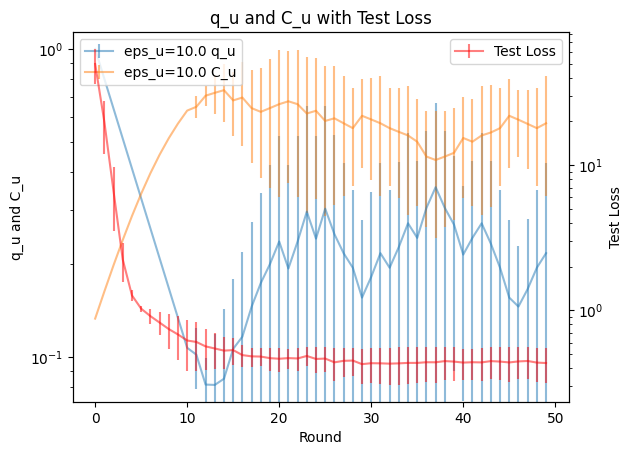

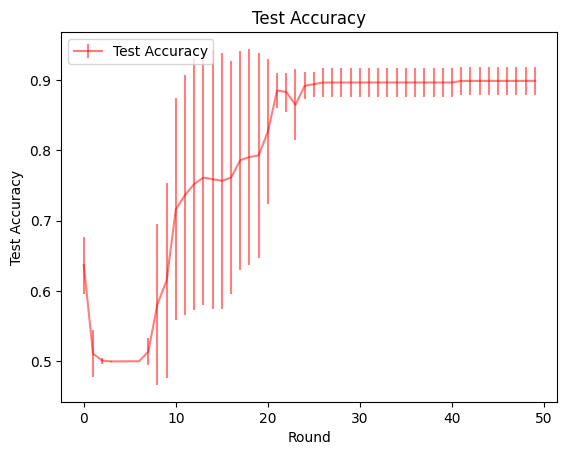

In [115]:
# creditcard with different number of users
n_users_list = [100, 1000, 2000]
global_learning_rate_list = [10.0, 20.0, 20.0]

sigma = 0.5
epsilon_list = [10.0]
group_thresholds = [10.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'creditcard'
n_round=50
times = 3
q_step_size = 0.8

for n_users, global_learning_rate in zip(n_users_list, global_learning_rate_list):
    print("n_users:", n_users)
    run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=10.0)
    show_online_optimization_result(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size)


n_users: 2000
Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=2000, n_silos=5, user_dist='zipf-iid', silo_dist='zipf', user_alpha=0.3, silo_alpha=1.5, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=50, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='PULDP-AVG-online', group_k=2, sigma=1.0, clipping_bound=1.0, delta=1e-05, sampling_rate_q=0.1, verbose=0, hyper_parameter_tuning=None, times=5, exp_dist=None, version=0, C_u=None, q_u=None, q_step_size=0.8, epsilon_u={0: 5.0, 1: 5.0, 2: 5.0, 3: 5.0, 4: 5.0, 5: 5.0, 6: 5.0, 7: 5.0, 8: 5.0, 9: 5.0, 10: 5.0, 11: 5.0, 12: 5.0, 13: 5.0, 14: 5.0, 15: 5.0, 16: 5.0, 17: 5.0, 18: 5.0, 19: 5.0, 20: 5.0, 21: 5.0, 22: 5.0, 23: 5.0, 24: 5.0, 25: 5.0, 26: 5.0, 27: 5.0, 28: 5.0, 29: 5.0, 30: 5.0, 31: 5.0, 32: 5.0, 33: 5.0, 34: 5.0, 35: 5.0, 36: 5.0, 37: 5.0, 38: 5.0, 39: 5.0, 40: 5.0, 4

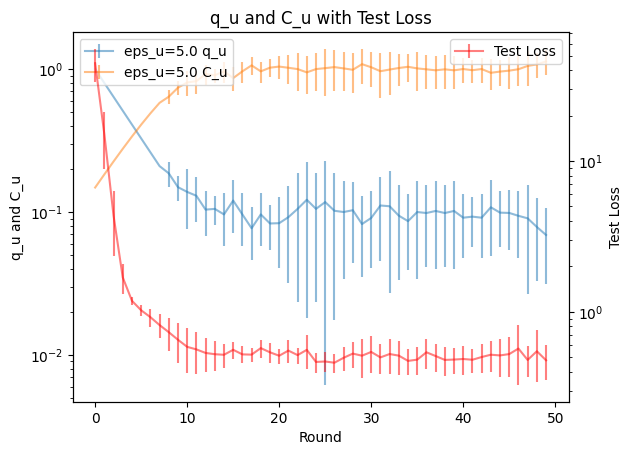

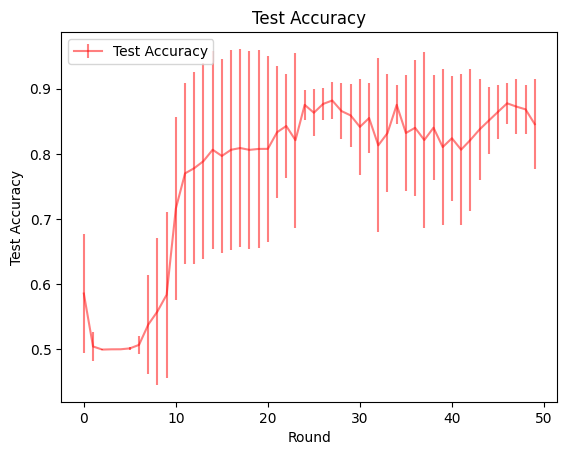

In [116]:
# creditcard with different number of users
n_users_list = [2000]
global_learning_rate_list = [10.0]

sigma = 1.0
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'creditcard'
n_round = 50
times = 5
q_step_size = 0.8

for n_users, global_learning_rate in zip(n_users_list, global_learning_rate_list):
    print("n_users:", n_users)
    run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=global_learning_rate)
    show_online_optimization_result(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size)


In [114]:
logger_set_info()
fed_simulation(
  delta=1e-5, sigma=5.0, n_users=100, C_u=None, q_u=None, q_step_size=q_step_size, agg_strategy="ULDP-AVG-w",
  times=3, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
  global_learning_rate=10.0, local_learning_rate=0.01, dataset_name=dataset_name, clipping_bound=0.1,
  local_epochs=30,
)

Namespace(seed=0, gpu_id=None, silo_id=None, dataset_name='creditcard', model_name='cnn', n_users=100, n_silos=5, user_dist='zipf-iid', silo_dist='zipf', user_alpha=0.3, silo_alpha=1.5, n_labels=1, typical_scenaio=None, n_silo_per_round=5, n_total_round=50, local_epochs=30, local_learning_rate=0.01, global_learning_rate=10.0, local_batch_size=64, weight_decay=0.001, client_optimizer='sgd', agg_strategy='ULDP-AVG-w', group_k=2, sigma=5.0, clipping_bound=0.1, delta=1e-05, sampling_rate_q=0.1, verbose=0, hyper_parameter_tuning=None, times=3, exp_dist=None, version=0, C_u=None, q_u=None, q_step_size=0.8, epsilon_u=None, group_thresholds=None, dry_run=False, secure_w=False)
[23:06:26 INFO] Start federated learning simulation
[23:07:08 INFO] Privacy spent: epsilon = 0.794522032537103 (round 0)
[23:07:09 INFO] |----- Global test result of round 0
[23:07:09 INFO] 	 |----- Test/ROC_AUC: 0.6654134790389714 (42722), Test/Loss: 61.885989248752594
[23:07:09 INFO] 

========== end 0-th round trainin

KeyboardInterrupt: 

In [83]:
# mnist with different number of users
n_users_list = [100, 1000]
global_learning_rate_list = [5.0, 10.0]

sigma = 0.5
epsilon_list = [5.0]
group_thresholds = [5.0]
ratio_list = [1.0]
delta = 1e-5
dataset_name = 'mnist'
n_round = 30
times = 3

for n_users, global_learning_rate in zip(n_users_list, global_learning_rate_list):
    print("n_users:", n_users)
    run_online_optimization(n_users, sigma, epsilon_list, group_thresholds, ratio_list, delta, dataset_name, n_round, q_step_size, times, global_learning_rate=global_learning_rate)


n_users: 100


KeyboardInterrupt: 

## Multiple Epsilons

In [ ]:
n_users = 300
sigma = 5.0
epsilon_list = [1.0, 5.0, 10.0]
group_thresholds = epsilon_list
ratio_list = [0.3, 0.4, 0.3]
delta = 1e-5
dataset_name = 'heart_disease'
n_round=30
times = 5

epsilon_u = make_epsilon_u(n_users=n_users, dist="hetero", epsilon_list=epsilon_list, ratio_list=ratio_list)
result = fed_simulation(
    delta, sigma, n_users, C_u=None, q_u=None, agg_strategy="PULDP-AVG-online",
    times=times, n_round=n_round, user_dist="zipf-iid", silo_dist="zipf", 
    global_learning_rate=10.0, local_learning_rate=0.01, dataset_name=dataset_name,
    local_epochs=30,
    epsilon_u=epsilon_u,
    group_thresholds=group_thresholds,
)

with open(os.path.join(pickle_path, f'result_{n_users}_{sigma}_{epsilon_list}_{group_thresholds}_{ratio_list}_{delta}_{dataset_name}_{n_round}.pkl'), 'wb') as file:
    pickle.dump(result, file)
